MoA: Pytorch-RankGauss-PCA-NN upgrade & 3D visual との差分を※で説明する


# ①データ、ライブラリ読み込み
---



In [ ]:
# Gドライブをマウント
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#データの読み込み
import pandas as pd

train_features_original = pd.read_csv('gdrive/My Drive/train_features.csv')
train_drug_original = pd.read_csv('gdrive/My Drive/train_drug.csv')
train_targets_original = pd.read_csv('gdrive/My Drive/train_targets_scored.csv')
train_targets_nonscored_original = pd.read_csv('gdrive/My Drive/train_targets_nonscored.csv')
test_features_original = pd.read_csv('gdrive/My Drive/test_features.csv')
columns_original = pd.read_csv('gdrive/My Drive/train_targets_scored.csv')
sample_original = pd.read_csv('gdrive/My Drive/sample_submission.csv')

In [ ]:
#データコピー
train_features = train_features_original.copy()
train_targets_scored = train_targets_original.copy()
train_targets_nonscored = train_targets_nonscored_original.copy()
test_features = test_features_original.copy()
sample_submission = sample_original.copy()
train_drug=train_drug_original.copy()

#ライブラリインポート
!pip install iterative-stratification
!pip install japanize_matplotlib
!pip install imbalanced-learn==0.7.0
import japanize_matplotlib
import numpy as np
import random
import pandas as pd
import os
import copy
import gc


import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA , TruncatedSVD
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import scipy.stats as stats
from scipy.stats import kurtosis

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.loss import _WeightedLoss

import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns', 2000)

     |████████████████████████████████| 4.1MB 9.2MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-cp36-none-any.whl size=4120275 sha256=acdb1821fc24cf38a2e387f4e9eeb51c29e6078d5d3e17feefed8d1072b87375
  Stored in directory: /root/.cache/pip/wheels/b7/d9/a2/f907d50b32a2d2008ce5d691d30fb6569c2c93eefcfde55202
Successfully built japanize-matplotlib
     |████████████████████████████████| 174kB 8.6MB/s 
     |████████████████████████████████| 6.8MB 22.8MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [ ]:
train_features2=train_features.copy()
test_features2=test_features.copy()

In [ ]:
#パラメータの指定
n_comp_GENES = 600
n_comp_CELLS = 50
VarianceThreshold_for_FS = 0.85
Dropout_Model = 0.25
print('n_comp_GENES', n_comp_GENES, 'n_comp_CELLS', n_comp_CELLS, 'total', n_comp_GENES + n_comp_CELLS)

n_comp_GENES 600 n_comp_CELLS 50 total 650


# ②RankGauss処理を実施

In [ ]:
GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]

In [ ]:
# RankGauss - transform to Gauss
qt = QuantileTransformer(n_quantiles=100,random_state=42,output_distribution='normal')
data = pd.concat([pd.DataFrame(train_features[GENES+CELLS]), pd.DataFrame(test_features[GENES+CELLS])])
data2 = qt.fit_transform(data[GENES+CELLS])
train_features[GENES+CELLS] = pd.DataFrame(data2[:train_features.shape[0]])
test_features[GENES+CELLS] = pd.DataFrame(data2[-test_features.shape[0]:])

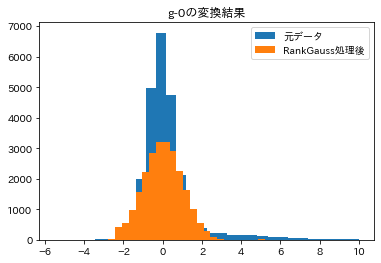

In [ ]:
#結果の確認
plt.hist(train_features_original['g-0'],bins=30,label='元データ')
plt.hist(train_features['g-0'],bins=30,label='RankGauss処理後')
plt.title('g-0の変換結果')
plt.legend()
plt.show()

In [ ]:
#seedの設定
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
seed_everything(42)

# ③PCAの実施

In [ ]:
#GENES
n_comp = 600  #<--Update

data = pd.concat([pd.DataFrame(train_features[GENES]), pd.DataFrame(test_features[GENES])])
data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[GENES]))
train2 = data2[:train_features.shape[0]]; 
test2 = data2[-test_features.shape[0]:]

train_gpca = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp)])
test_gpca = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(GENES))]
train_features = pd.concat((train_features, train_gpca), axis=1)
test_features = pd.concat((test_features, test_gpca), axis=1)

In [ ]:
#CELLS
n_comp = 50  #<--Update

data = pd.concat([pd.DataFrame(train_features[CELLS]), pd.DataFrame(test_features[CELLS])])
data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[CELLS]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train_cpca = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp)])
test_cpca = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(CELLS))]
train_features = pd.concat((train_features, train_cpca), axis=1)
test_features = pd.concat((test_features, test_cpca), axis=1)

# ④変数選択

In [ ]:
from sklearn.feature_selection import VarianceThreshold

data = train_features.append(test_features)
data

sig_id cp_type  cp_time cp_dose       g-0       g-1       g-2  \
0     id_000644bb2  trt_cp       24      D1  1.146806  0.902075 -0.418339   
1     id_000779bfc  trt_cp       72      D1  0.128824  0.676862  0.274345   
2     id_000a6266a  trt_cp       48      D1  0.790372  0.939951  1.428097   
3     id_0015fd391  trt_cp       48      D1 -0.729866 -0.277163 -0.441200   
4     id_001626bd3  trt_cp       72      D2 -0.444558 -0.481202  0.974729   
...            ...     ...      ...     ...       ...       ...       ...   
3977  id_ff7004b87  trt_cp       24      D1  0.610179 -0.693216  2.335324   
3978  id_ff925dd0d  trt_cp       24      D1 -0.841490 -0.284745  2.001757   
3979  id_ffb710450  trt_cp       72      D1 -0.556729 -0.150783  0.236686   
3980  id_ffbb869f2  trt_cp       48      D2 -1.595055 -1.938612 -0.620069   
3981  id_ffd5800b6  trt_cp       72      D1 -0.735140  0.504683  0.308978   

           g-3       g-4       g-5       g-6       g-7       g-8       g-9  \
0    -0.961202 -0.254770 -1.021300 -1.369236 -0.029888  0.684319 -0.316668   
1     0.090495  1.208863  0.688965  0.316734  0.556428 -0.539718  0.831972   
2    -0.121817 -0.002067  1.495091  0.238763  0.363471 -0.003611  1.237966   
3     0.766612  2.347817 -0.862761 -2.308829  0.305225 -0.191898 -1.389591   
4     0.977467  1.468304 -0.874772 -0.372682 -0.212171 -1.067075  0.844018   
...        ...       ...       ...       ...       ...       ...       ...   
3977 -0.960274  1.077581  1.787902  0.096095 -0.786532 -1.300329  0.705155   
3978  0.514078  0.648849  0.432057 -1.005135 -0.000512  0.319340  1.878168   
3979 -1.047790  0.069175  0.638279 -0.017961  1.184037  0.032537  1.395508   
3980  1.328228 -1.629275 -0.261974 -0.483282 -1.291110  1.180377  0.642779   
3981 -0.070002 -0.077160  1.097412 -1.175262  0.633623 -0.076225  0.239420   

          g-10      g-11      g-12      g-13      g-14      g-15      g-16  \
0     1.526881  0.180196  0.621873 -0.557740  0.282621 -1.060673 -1.139906   
1    -1.255140 -0.573112 -0.208841  0.549210  0.149726  0.394322  0.402269   
2    -0.644480 -0.768445 -0.127136 -2.323163  0.882413 -0.547770  0.473795   
3    -1.005581 -0.491974 -1.143377 -0.815236 -1.776327  1.392344 -0.225631   
4    -0.339762 -0.701653 -1.243135  1.187418  0.319514  0.344687 -0.023876   
...        ...       ...       ...       ...       ...       ...       ...   
3977  0.322292  0.955805  0.848723 -0.960014 -0.805360 -1.733836 -0.022009   
3978  0.219671  0.475734  0.945597 -1.364069  0.276507  2.260132  1.314133   
3979  0.579934 -0.583146 -0.240560 -0.384273  0.650549 -1.261716 -0.398031   
3980  1.858832  0.780629  1.244134  1.318525  1.400679  0.823669 -0.383771   
3981  0.268416  0.297418 -0.274628  1.374642 -0.649541  1.314408  0.497476   

          g-17      g-18      g-19      g-20      g-21      g-22      g-23  \
0     0.876619  0.385452 -0.511010 -0.724484 -1.333353 -1.670424  1.247499   
1     0.404046 -0.837129  0.501094  1.241742 -0.134523 -0.390085 -0.444660   
2    -0.402984 -0.308666 -0.040736 -0.109697 -1.008389 -1.938291  0.532560   
3    -1.054686  0.248900 -2.125619  2.088503 -1.355700 -1.091855 -1.063889   
4    -1.570681 -0.846636 -0.705536 -0.447726 -0.293294  1.066411  0.492235   
...        ...       ...       ...       ...       ...       ...       ...   
3977  0.388722  0.798895 -1.417242  1.293600 -0.949683  0.979444  1.512552   
3978 -0.244642  0.760795  0.891411  0.841719 -0.926246 -0.243715  0.731217   
3979  1.316764  0.962298 -1.223872 -1.346067 -0.164525 -0.304638  0.731217   
3980  0.717470  0.031540 -0.119935  1.235857 -1.794392  0.337382 -1.038692   
3981  0.595302 -1.143457 -1.857612  0.039088  0.470395 -1.254901  0.114185   

          g-24      g-25      g-26      g-27      g-28      g-29      g-30  \
0     0.561705  0.406613  0.238226  0.161995 -0.521300  0.776699  0.419961   
1     0.396115 -0.581092  0.624671  0.217307 -0.744494 -0.189269 -0.121230   
2     0.626405  0.702705 -1.385532  2.3919

In [ ]:
#分散が0.9以下の変数を削除する
var_thresh = VarianceThreshold(0.85)
data = train_features.append(test_features)
data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])

In [ ]:
#削除された変数を確認
remove_column_list=data.columns[4:][np.logical_not(var_thresh.get_support())]
remove_column_list

Index(['pca_G-145', 'pca_G-146', 'pca_G-147', 'pca_G-148', 'pca_G-149',
       'pca_G-150', 'pca_G-151', 'pca_G-152', 'pca_G-153', 'pca_G-154',
       ...
       'pca_C-40', 'pca_C-41', 'pca_C-42', 'pca_C-43', 'pca_C-44', 'pca_C-45',
       'pca_C-46', 'pca_C-47', 'pca_C-48', 'pca_C-49'],
      dtype='object', length=498)

In [ ]:
#削除された説明変数の分散を確認
data[remove_column_list].var().max()

0.8461690596894942

In [ ]:
#削除した結果をデータフレームに格納
train_features_transformed = data_transformed[ : train_features.shape[0]]
test_features_transformed = data_transformed[-test_features.shape[0] : ]


train_features = pd.DataFrame(train_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                              columns=['sig_id','cp_type','cp_time','cp_dose'])

train_features = pd.concat([train_features, pd.DataFrame(train_features_transformed)], axis=1)

test_features = pd.DataFrame(test_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                             columns=['sig_id','cp_type','cp_time','cp_dose'])

test_features = pd.concat([test_features, pd.DataFrame(test_features_transformed)], axis=1)

In [ ]:
train_features.head()

sig_id cp_type cp_time cp_dose         0         1         2  \
0  id_000644bb2  trt_cp      24      D1  1.146806  0.902075 -0.418339   
1  id_000779bfc  trt_cp      72      D1  0.128824  0.676862  0.274345   
2  id_000a6266a  trt_cp      48      D1  0.790372  0.939951  1.428097   
3  id_0015fd391  trt_cp      48      D1 -0.729866 -0.277163 -0.441200   
4  id_001626bd3  trt_cp      72      D2 -0.444558 -0.481202  0.974729   

          3         4         5         6         7         8         9  \
0 -0.961202 -0.254770 -1.021300 -1.369236 -0.029888  0.684319 -0.316668   
1  0.090495  1.208863  0.688965  0.316734  0.556428 -0.539718  0.831972   
2 -0.121817 -0.002067  1.495091  0.238763  0.363471 -0.003611  1.237966   
3  0.766612  2.347817 -0.862761 -2.308829  0.305225 -0.191898 -1.389591   
4  0.977467  1.468304 -0.874772 -0.372682 -0.212171 -1.067075  0.844018   

         10        11        12        13        14        15        16  \
0  1.526881  0.180196  0.621873 -0.557740  0.282621 -1.060673 -1.139906   
1 -1.255140 -0.573112 -0.208841  0.549210  0.149726  0.394322  0.402269   
2 -0.644480 -0.768445 -0.127136 -2.323163  0.882413 -0.547770  0.473795   
3 -1.005581 -0.491974 -1.143377 -0.815236 -1.776327  1.392344 -0.225631   
4 -0.339762 -0.701653 -1.243135  1.187418  0.319514  0.344687 -0.023876   

         17        18        19        20        21        22        23  \
0  0.876619  0.385452 -0.511010 -0.724484 -1.333353 -1.670424  1.247499   
1  0.404046 -0.837129  0.501094  1.241742 -0.134523 -0.390085 -0.444660   
2 -0.402984 -0.308666 -0.040736 -0.109697 -1.008389 -1.938291  0.532560   
3 -1.054686  0.248900 -2.125619  2.088503 -1.355700 -1.091855 -1.063889   
4 -1.570681 -0.846636 -0.705536 -0.447726 -0.293294  1.066411  0.492235   

         24        25        26        27        28        29        30  \
0  0.561705  0.406613  0.238226  0.161995 -0.521300  0.776699  0.419961   
1  0.396115 -0.581092  0.624671  0.217307 -0.744494 -0.189269 -0.121230   
2  0.626405  0.702705 -1.385532  2.391969 -0.096834  1.591787 -1.465673   
3 -1.427285  0.004132 -1.057524  0.260284 -0.458109 -1.253958 -0.979995   
4  1.679156  1.005323  1.072014 -0.557841 -1.541019  0.373345 -0.154493   

         31        32        33        34        35        36        37  \
0 -1.097407 -0.055064 -0.443270 -0.201534  0.276058  0.384696 -0.595063   
1 -0.548652  1.663916 -0.372043  0.352630 -0.284155  0.202425  0.779231   
2  0.815105  0.737461  0.205613 -0.002542 -1.668236  0.147685 -0.161838   
3  0.126880 -2.099980  1.039492  0.781420 -2.137240 -1.418522 -1.066719   
4  0.845777  1.137909 -0.143263  1.489803 -1.022238 -1.330391  1.621226   

         38        39        40        41        42        43        44  \
0 -0.737635 -0.371308 -0.006239 -0.339561 -1.362035  0.425598 -1.255837   
1 -0.354288 -0.091953  0.211233 -0.521036 -1.344257  0.619376  1.862098   
2  1.703524  1.312477  0.553992 -0.721329  0.100235 -0.536122 -0.577234   
3  1.418550 -0.639416 -0.884448 -0.000320  0.247921 -2.042377 -0.926970   
4  0.775831 -0.155422  0.227374  0.169476  1.430737  0.280764  0.842108   

         45        46        47        48        49        50        51  \
0  0.330148 -0.343777 -0.022419  0.063678  0.700528 -0.186176 -0.658055   
1  1.335946  0.559412 -0.505327  0.238561 -1.095490  1.796571 -0.672133   
2 -0.788790  0.248539 -1.062270 -0.663437  0.743189 -0.154016 -0.347725   
3 -0.998886 -0.413876  0.125047 -0.642957  1.026522 -1.328480 -0.807607   
4  1.390495  1.482106 -1.280198 -0.491167 -0.998114 -0.129378 -0.508307   

         52        53        54        55        56        57        58  \
0  0.842025  0.567073 -0.148693 -0.228843 -0.769898  0.272742  0.801183   
1 -0.359793 -1.004930 -0.772445 -0.174592 -0.732133  0.580915  0.440352   
2  0.833083  0.322658 -1.088618 -0.603816  1.378014  0.056462 -0.261232   
3 -1.440925  1.714855 -0.935790 -1.360094 -0.691351  0.529634  0.094990   
4  0.950318 -0.027241  0.155273  1.649

In [ ]:
train_features.shape

(23814, 1028)

# ⑤ K-Meansを実施、特徴量作成

In [ ]:
#g-に関してK-Meansでクラスターを作成
#クラスターについてダミー変数化
from sklearn.cluster import KMeans
def fe_cluster(train, test, n_clusters_g = 22, n_clusters_c = 4, SEED = 42):
    
    features_g = GENES
    features_c = CELLS
    
    def create_cluster(train, test, features, kind = 'g', n_clusters = n_clusters_g):
        train_ = train[features].copy()
        test_ = test[features].copy()
        data = pd.concat([train_, test_], axis = 0)
        kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data)
        train[f'clusters_{kind}'] = kmeans.labels_[:train.shape[0]]
        test[f'clusters_{kind}'] = kmeans.labels_[train.shape[0]:]
        train = pd.get_dummies(train, columns = [f'clusters_{kind}'])
        test = pd.get_dummies(test, columns = [f'clusters_{kind}'])
        return train, test
    
    train, test = create_cluster(train, test, features_g, kind = 'g', n_clusters = n_clusters_g)
    train, test = create_cluster(train, test, features_c, kind = 'c', n_clusters = n_clusters_c)
    return train, test

train_features2 ,test_features2=fe_cluster(train_features2,test_features2)

In [ ]:
train_features2.head()

sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   
3  id_0015fd391  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288   
4  id_001626bd3  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919   

      g-4     g-5     g-6     g-7     g-8     g-9    g-10    g-11    g-12  \
0 -0.1944 -1.0120 -1.0220 -0.0326  0.5548 -0.0921  1.1830  0.1530  0.5574   
1  1.0190  0.5207  0.2341  0.3372 -0.4047  0.8507 -1.1520 -0.4201 -0.0958   
2 -0.0323  1.2390  0.1715  0.2155  0.0065  1.2300 -0.4797 -0.5631 -0.0366   
3  4.0620 -0.8095 -1.9590  0.1792 -0.1321 -1.0600 -0.8269 -0.3584 -0.8511   
4  1.4180 -0.8244 -0.2800 -0.1498 -0.8789  0.8630 -0.2219 -0.5121 -0.9577   

     g-13    g-14    g-15    g-16    g-17    g-18    g-19    g-20    g-21  \
0 -0.4015  0.1789 -0.6528 -0.7969  0.6342  0.1778 -0.3694 -0.5688 -1.1360   
1  0.4590  0.0803  0.2250  0.5293  0.2839 -0.3494  0.2883  0.9449 -0.1646   
2 -1.8300  0.6057 -0.3278  0.6042 -0.3075 -0.1147 -0.0570 -0.0799 -0.8181   
3 -0.5844 -2.5690  0.8183 -0.0532 -0.8554  0.1160 -2.3520  2.1200 -1.1580   
4  1.1750  0.2042  0.1970  0.1244 -1.7090 -0.3543 -0.5160 -0.3330 -0.2685   

     g-22    g-23    g-24    g-25    g-26    g-27    g-28    g-29    g-30  \
0 -1.1880  0.6940  0.4393  0.2664  0.1907  0.1628 -0.2853  0.5819  0.2934   
1 -0.2657 -0.3372  0.3135 -0.4316  0.4773  0.2075 -0.4216 -0.1161 -0.0499   
2 -1.5320  0.2307  0.4901  0.4780 -1.3970  4.6240 -0.0437  1.2870 -1.8530   
3 -0.7191 -0.8004 -1.4670 -0.0107 -0.8995  0.2406 -0.2479 -1.0890 -0.7575   
4  0.7649  0.2057  1.3720  0.6835  0.8056 -0.3754 -1.2090  0.2965 -0.0712   

     g-31    g-32    g-33    g-34    g-35    g-36    g-37    g-38    g-39  \
0 -0.5584 -0.0916 -0.3010 -0.1537  0.2198  0.2965 -0.5055 -0.5119 -0.2162   
1 -0.2627  0.9959 -0.2483  0.2655 -0.2102  0.1656  0.5300 -0.2568 -0.0455   
2  0.6069  0.4290  0.1783  0.0018 -1.1800  0.1256 -0.1219  5.4470  1.0310   
3  0.0881 -2.7370  0.8745  0.5787 -1.6740 -1.6720 -1.2690  3.0900 -0.3814   
4  0.6389  0.6674 -0.0783  1.1740 -0.7110 -1.4470  1.0620  0.7888 -0.0848   

     g-40    g-41    g-42    g-43    g-44    g-45    g-46    g-47    g-48  \
0 -0.0347 -0.2566 -1.1980  0.3116 -1.0330  0.2208 -0.1143 -0.0251  0.0350   
1  0.1194 -0.3958 -1.1730  0.4509  1.9250  1.1010  0.2648 -0.3615  0.1710   
2  0.3477 -0.5561  0.0357 -0.3636 -0.4653 -0.8346  0.1113 -0.7615 -0.4983   
3 -0.7229 -0.0010  0.1353 -1.6400 -0.7483 -1.0820 -0.1521  0.0747 -0.4851   
4  0.1302  0.1224  0.9584  0.2126  0.6162  1.1570  1.1140 -0.9416 -0.3780   

     g-49    g-50    g-51    g-52    g-53    g-54    g-55    g-56    g-57  \
0  0.4233 -0.1221 -0.4927  0.6119  0.4715 -0.0351 -0.1605 -0.6750  0.2263   
1 -0.8900  1.2730 -0.5036 -0.2277 -0.7339 -0.4283 -0.1231 -0.6328  0.4759   
2  0.4552 -0.0978 -0.2661  0.6058  0.2686 -0.6191 -0.4444  1.2540  0.0621   
3  0.6636 -2.8230 -0.6035 -1.3550  2.0200 -0.5301 -1.3240 -0.5936  0.4331   
4 -0.8147 -0.0803 -0.3818  0.6877  0.0000  0.1776  1.1320 -0.1180  1.2130   

     g-58    g-59    g-60    g-61    g-62    g-63    g-64    g-65    g-66  \
0  0.5790  0.9588  0.6061 -0.1300  0.6611 -0.3136 -0.2020  0.0251  0.1670   
1  0.3249 -0.7408 -0.5814  1.7840 -0.1087  1.0350  0.4087 -0.6948 -0.8026   
2 -0.1757 -1.4370  0.5553  0.8346 -0.3334 -0.2933 -0.1644 -1.1280 -0.0292   
3  0.0899 -1.5240  0.3936  1.4630 -1.2100 -1.2340 -1.0300  0.7977  0.2314   
4  0.7709  0.6745  0.7871  1.6410  0.1806  1.3480  1.1070  0.5392  0.0000   

     g-67    g-68    g-69    g-70    g-71    g-72    g-73    g-74    g-75  \
0 -0.4195  0.6551 -0.7395 -0.7047 -0.5369  0.0314 -0.5239 -0.3406 -0.6332   
1  0.0954 -0.4054  0.1197  0.1956  0.0720 -0.2463 -0.1084  0.4008 -0.5857   
2  0.0939  0.5916  0.6809  0.7821  0.6801  0.9634  0.4057 -0.0708 -1.3570   
3  

In [ ]:
train_pca=pd.concat((train_gpca,train_cpca),axis=1)
test_pca=pd.concat((test_gpca,test_cpca),axis=1)
train_pca.head()

pca_G-0   pca_G-1    pca_G-2   pca_G-3   pca_G-4   pca_G-5   pca_G-6  \
0  -5.509135  3.934672   9.358451 -7.911861  4.834325  0.834668  3.446985   
1  -4.899750  3.891428 -11.376574  5.777669  0.924188  0.258293  1.041124   
2   1.258620 -7.242684  -5.448532 -0.802672  0.922407  3.698523 -1.905278   
3  11.514493 -8.717475  -4.263702 -5.765282 -7.029854 -2.680401 -2.229116   
4  -6.541055 -2.337753 -10.742705 -4.184780 -8.086348 -8.202837 -4.266611   

    pca_G-7   pca_G-8   pca_G-9  pca_G-10  pca_G-11  pca_G-12  pca_G-13  \
0  1.625308  0.909537  2.112349 -0.773065  1.595258  2.346131  0.174161   
1 -0.395364  5.401568  1.449645  0.533037 -0.712049 -0.484181 -0.791555   
2  2.625305 -4.668135  0.999668 -0.644918  0.340928  2.098466 -1.472193   
3  6.561454 -2.617044 -3.505768  3.897620 -3.320628 -4.289316  0.593817   
4 -3.182038 -1.694953  0.846413  3.021368 -2.211377 -1.869865  3.364146   

   pca_G-14  pca_G-15  pca_G-16  pca_G-17  pca_G-18  pca_G-19  pca_G-20  \
0  1.383543 -0.594630  0.218454  0.154123  1.317228 -0.202818  0.634928   
1 -0.141316  1.132515 -2.373763 -0.395762 -0.441959 -0.742251  1.435064   
2  1.073232  0.334549 -1.944031 -1.496131  1.070153  1.789297 -2.304432   
3  0.208027 -0.425354  0.470543 -0.531908 -1.162864  2.874744 -2.605948   
4 -4.546725 -1.942870 -0.340804  0.583586  2.873187  1.644729 -0.692309   

   pca_G-21  pca_G-22  pca_G-23  pca_G-24  pca_G-25  pca_G-26  pca_G-27  \
0 -1.757719 -0.158942 -0.008059 -1.448548  1.850376  0.954259 -0.672085   
1  1.562435 -2.076895 -0.161911 -2.381963 -2.155885  0.873543 -0.302340   
2 -1.001661  1.875194 -1.870294 -0.240427 -1.380280 -1.353406 -1.368998   
3 -0.497659  0.106770 -0.958126 -2.274531 -1.373384  0.719689 -1.267852   
4 -0.433914  0.713779 -1.577429 -1.260329 -3.460191  0.471724  0.922686   

   pca_G-28  pca_G-29  pca_G-30  pca_G-31  pca_G-32  pca_G-33  pca_G-34  \
0 -0.884556 -0.484137 -0.876444 -0.265378 -0.249748  1.627808 -0.205128   
1  0.651676  1.004747 -2.498218  0.001514  1.743405  1.555324  2.615868   
2 -1.138669 -0.345230 -0.804093 -3.225608 -0.439712 -1.253922 -1.824056   
3 -1.693953  1.214216 -3.209241  2.667179 -2.222022  1.853063  1.240051   
4  0.901466  0.787218 -0.215454  1.463519  0.852887  1.297612  3.386939   

   pca_G-35  pca_G-36  pca_G-37  pca_G-38  pca_G-39  pca_G-40  pca_G-41  \
0 -0.563254  1.731007 -0.278340  1.705286  0.089906  0.486405 -0.303624   
1  0.147452 -1.186338  1.572955  0.308444  1.697502 -0.467152 -0.697195   
2  2.467165 -1.474693 -3.266512  2.222424 -0.308035  2.283413  2.153884   
3 -1.212201 -2.241388 -5.504667 -4.471877 -0.299328  0.436693  0.705756   
4 -1.268042  0.421183  0.734664 -3.022795 -0.193648 -0.257452 -2.074893   

   pca_G-42  pca_G-43  pca_G-44  pca_G-45  pca_G-46  pca_G-47  pca_G-48  \
0  0.626759  2.095216 -1.224640 -0.570256 -0.331921  0.673780  1.251264   
1  0.452530 -1.049905  0.876106 -0.847179 -0.967715  0.167682  0.801105   
2 -1.720848 -0.493430  0.433521  0.169721  2.740812 -0.159481  1.997235   
3  0.678045  2.491020  0.443769  1.094787 -1.199681  1.195276  0.119257   
4 -0.909454  0.257403  1.081682  1.260247  0.227546  1.274088 -1.673060   

   pca_G-49  pca_G-50  pca_G-51  pca_G-52  pca_G-53  pca_G-54  pca_G-55  \
0  0.063099  0.895410  0.534556 -0.632716 -1.257202  0.913299  0.046043   
1  0.908299  0.232944  1.112632 -0.048039  0.890046 -0.021887  0.128168   
2  1.796173 -0.340003  0.856069  1.093192  2.167489  0.572404 -0.590947   
3  0.202052  0.183785  0.881548  1.375612  1.581158 -0.211922 -0.474408   
4 -0.609013 -0.850221  0.848420 -1.328800  1.071378 -3.141272  0.679705   

   pca_G-56  pca_G-57  pca_G-58  pca_G-59  pca_G-60  pca_G-61  pca_G-62  \
0  0.789598 -1.673965 -1.465300 -0.509599 -0.738190  0.352169  0.213338   
1 -0.038607 -0.391883  1.819770 -0.400402 -0.795844  3.082336 -1.219069   
2 -1.350618 -2.777928  2.594043  1.711768 -1.008681 -0.717060  0.787285   
3  1.561994  0.520707 -0.567840 -0.880860 -0.500624 -0.993103  0.344603   
4 -1.32226

In [ ]:
#pcaの列に対して、K-Meansを実施
def fe_cluster_pca(train, test,n_clusters=5,SEED = 42):
        data=pd.concat([train,test],axis=0)
        kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data)
        train[f'clusters_pca'] = kmeans.labels_[:train.shape[0]]
        test[f'clusters_pca'] = kmeans.labels_[train.shape[0]:]
        train = pd.get_dummies(train, columns = [f'clusters_pca'])
        test = pd.get_dummies(test, columns = [f'clusters_pca'])
        return train, test
train_cluster_pca ,test_cluster_pca = fe_cluster_pca(train_pca,test_pca)

In [ ]:
train_cluster_pca = train_cluster_pca.iloc[:,650:]
test_cluster_pca = test_cluster_pca.iloc[:,650:]
train_cluster_pca.head()

clusters_pca_0  clusters_pca_1  clusters_pca_2  clusters_pca_3  \
0               0               0               0               1   
1               0               1               0               0   
2               0               1               0               0   
3               0               0               1               0   
4               0               1               0               0   

   clusters_pca_4  
0               0  
1               0  
2               0  
3               0  
4               0

In [ ]:
train_features_cluster=train_features2.iloc[:,876:]
test_features_cluster=test_features2.iloc[:,876:]
train_features_cluster.head()

clusters_g_0  clusters_g_1  clusters_g_2  clusters_g_3  clusters_g_4  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             1   
4             0             0             0             0             0   

   clusters_g_5  clusters_g_6  clusters_g_7  clusters_g_8  clusters_g_9  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   clusters_g_10  clusters_g_11  clusters_g_12  clusters_g_13  clusters_g_14  \
0              0              0              0              0              1   
1              1              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   clusters_g_15  clusters_g_16  clusters_g_17  clusters_g_18  clusters_g_19  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              1              0   
3              0              0              0              0              0   
4              0              0              0              1              0   

   clusters_g_20  clusters_g_21  clusters_c_0  clusters_c_1  clusters_c_2  \
0              0              0             0             0             1   
1              0              0             0             0             1   
2              0              0             0             0             1   
3              0              0             1             0             0   
4              0              0             0             0             1   

   clusters_c_3  
0             0  
1             0  
2             0  
3             0  
4             0

# ⑥統計量、交互作用、2乗の特徴量を作成

In [ ]:
train_features2.shape

(23814, 902)

In [ ]:
gsquarecols=['g-574','g-211','g-216','g-0','g-255','g-577','g-153','g-389','g-60','g-370','g-248','g-167','g-203','g-177','g-301','g-332','g-517','g-6','g-744','g-224','g-162','g-3','g-736','g-486','g-283','g-22','g-359','g-361','g-440','g-335','g-106','g-307','g-745','g-146','g-416','g-298','g-666','g-91','g-17','g-549','g-145','g-157','g-768','g-568','g-396']

In [ ]:
def fe_stats(train, test):
    
    features_g = GENES
    features_c = CELLS
    
    for df in train, test:
        df['g_sum'] = df[features_g].sum(axis = 1)
        df['g_mean'] = df[features_g].mean(axis = 1)
        df['g_std'] = df[features_g].std(axis = 1)
        df['g_kurt'] = df[features_g].kurtosis(axis = 1)
        df['g_skew'] = df[features_g].skew(axis = 1)
        df['c_sum'] = df[features_c].sum(axis = 1)
        df['c_mean'] = df[features_c].mean(axis = 1)
        df['c_std'] = df[features_c].std(axis = 1)
        df['c_kurt'] = df[features_c].kurtosis(axis = 1)
        df['c_skew'] = df[features_c].skew(axis = 1)
        df['gc_sum'] = df[features_g + features_c].sum(axis = 1)
        df['gc_mean'] = df[features_g + features_c].mean(axis = 1)
        df['gc_std'] = df[features_g + features_c].std(axis = 1)
        df['gc_kurt'] = df[features_g + features_c].kurtosis(axis = 1)
        df['gc_skew'] = df[features_g + features_c].skew(axis = 1)
        
        df['c52_c42'] = df['c-52'] * df['c-42']
        df['c13_c73'] = df['c-13'] * df['c-73']
        df['c26_c13'] = df['c-23'] * df['c-13']
        df['c33_c6'] = df['c-33'] * df['c-6']
        df['c11_c55'] = df['c-11'] * df['c-55']
        df['c38_c63'] = df['c-38'] * df['c-63']
        df['c38_c94'] = df['c-38'] * df['c-94']
        df['c13_c94'] = df['c-13'] * df['c-94']
        df['c4_c52'] = df['c-4'] * df['c-52']
        df['c4_c42'] = df['c-4'] * df['c-42']
        df['c13_c38'] = df['c-13'] * df['c-38']
        df['c55_c2'] = df['c-55'] * df['c-2']
        df['c55_c4'] = df['c-55'] * df['c-4']
        df['c4_c13'] = df['c-4'] * df['c-13']
        df['c82_c42'] = df['c-82'] * df['c-42']
        df['c66_c42'] = df['c-66'] * df['c-42']
        df['c6_c38'] = df['c-6'] * df['c-38']
        df['c2_c13'] = df['c-2'] * df['c-13']
        df['c62_c42'] = df['c-62'] * df['c-42']
        df['c90_c55'] = df['c-90'] * df['c-55']
        
        
        for feature in features_c:
             df[f'{feature}_squared'] = df[feature] ** 2     
                
        for feature in gsquarecols:
            df[f'{feature}_squared'] = df[feature] ** 2        
        
    return train, test

train_features2,test_features2=fe_stats(train_features2,test_features2)
train_features2.head()

sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   
3  id_0015fd391  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288   
4  id_001626bd3  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919   

      g-4     g-5     g-6     g-7     g-8     g-9    g-10    g-11    g-12  \
0 -0.1944 -1.0120 -1.0220 -0.0326  0.5548 -0.0921  1.1830  0.1530  0.5574   
1  1.0190  0.5207  0.2341  0.3372 -0.4047  0.8507 -1.1520 -0.4201 -0.0958   
2 -0.0323  1.2390  0.1715  0.2155  0.0065  1.2300 -0.4797 -0.5631 -0.0366   
3  4.0620 -0.8095 -1.9590  0.1792 -0.1321 -1.0600 -0.8269 -0.3584 -0.8511   
4  1.4180 -0.8244 -0.2800 -0.1498 -0.8789  0.8630 -0.2219 -0.5121 -0.9577   

     g-13    g-14    g-15    g-16    g-17    g-18    g-19    g-20    g-21  \
0 -0.4015  0.1789 -0.6528 -0.7969  0.6342  0.1778 -0.3694 -0.5688 -1.1360   
1  0.4590  0.0803  0.2250  0.5293  0.2839 -0.3494  0.2883  0.9449 -0.1646   
2 -1.8300  0.6057 -0.3278  0.6042 -0.3075 -0.1147 -0.0570 -0.0799 -0.8181   
3 -0.5844 -2.5690  0.8183 -0.0532 -0.8554  0.1160 -2.3520  2.1200 -1.1580   
4  1.1750  0.2042  0.1970  0.1244 -1.7090 -0.3543 -0.5160 -0.3330 -0.2685   

     g-22    g-23    g-24    g-25    g-26    g-27    g-28    g-29    g-30  \
0 -1.1880  0.6940  0.4393  0.2664  0.1907  0.1628 -0.2853  0.5819  0.2934   
1 -0.2657 -0.3372  0.3135 -0.4316  0.4773  0.2075 -0.4216 -0.1161 -0.0499   
2 -1.5320  0.2307  0.4901  0.4780 -1.3970  4.6240 -0.0437  1.2870 -1.8530   
3 -0.7191 -0.8004 -1.4670 -0.0107 -0.8995  0.2406 -0.2479 -1.0890 -0.7575   
4  0.7649  0.2057  1.3720  0.6835  0.8056 -0.3754 -1.2090  0.2965 -0.0712   

     g-31    g-32    g-33    g-34    g-35    g-36    g-37    g-38    g-39  \
0 -0.5584 -0.0916 -0.3010 -0.1537  0.2198  0.2965 -0.5055 -0.5119 -0.2162   
1 -0.2627  0.9959 -0.2483  0.2655 -0.2102  0.1656  0.5300 -0.2568 -0.0455   
2  0.6069  0.4290  0.1783  0.0018 -1.1800  0.1256 -0.1219  5.4470  1.0310   
3  0.0881 -2.7370  0.8745  0.5787 -1.6740 -1.6720 -1.2690  3.0900 -0.3814   
4  0.6389  0.6674 -0.0783  1.1740 -0.7110 -1.4470  1.0620  0.7888 -0.0848   

     g-40    g-41    g-42    g-43    g-44    g-45    g-46    g-47    g-48  \
0 -0.0347 -0.2566 -1.1980  0.3116 -1.0330  0.2208 -0.1143 -0.0251  0.0350   
1  0.1194 -0.3958 -1.1730  0.4509  1.9250  1.1010  0.2648 -0.3615  0.1710   
2  0.3477 -0.5561  0.0357 -0.3636 -0.4653 -0.8346  0.1113 -0.7615 -0.4983   
3 -0.7229 -0.0010  0.1353 -1.6400 -0.7483 -1.0820 -0.1521  0.0747 -0.4851   
4  0.1302  0.1224  0.9584  0.2126  0.6162  1.1570  1.1140 -0.9416 -0.3780   

     g-49    g-50    g-51    g-52    g-53    g-54    g-55    g-56    g-57  \
0  0.4233 -0.1221 -0.4927  0.6119  0.4715 -0.0351 -0.1605 -0.6750  0.2263   
1 -0.8900  1.2730 -0.5036 -0.2277 -0.7339 -0.4283 -0.1231 -0.6328  0.4759   
2  0.4552 -0.0978 -0.2661  0.6058  0.2686 -0.6191 -0.4444  1.2540  0.0621   
3  0.6636 -2.8230 -0.6035 -1.3550  2.0200 -0.5301 -1.3240 -0.5936  0.4331   
4 -0.8147 -0.0803 -0.3818  0.6877  0.0000  0.1776  1.1320 -0.1180  1.2130   

     g-58    g-59    g-60    g-61    g-62    g-63    g-64    g-65    g-66  \
0  0.5790  0.9588  0.6061 -0.1300  0.6611 -0.3136 -0.2020  0.0251  0.1670   
1  0.3249 -0.7408 -0.5814  1.7840 -0.1087  1.0350  0.4087 -0.6948 -0.8026   
2 -0.1757 -1.4370  0.5553  0.8346 -0.3334 -0.2933 -0.1644 -1.1280 -0.0292   
3  0.0899 -1.5240  0.3936  1.4630 -1.2100 -1.2340 -1.0300  0.7977  0.2314   
4  0.7709  0.6745  0.7871  1.6410  0.1806  1.3480  1.1070  0.5392  0.0000   

     g-67    g-68    g-69    g-70    g-71    g-72    g-73    g-74    g-75  \
0 -0.4195  0.6551 -0.7395 -0.7047 -0.5369  0.0314 -0.5239 -0.3406 -0.6332   
1  0.0954 -0.4054  0.1197  0.1956  0.0720 -0.2463 -0.1084  0.4008 -0.5857   
2  0.0939  0.5916  0.6809  0.7821  0.6801  0.9634  0.4057 -0.0708 -1.3570   
3  

In [ ]:
train_features2.shape

(23814, 1082)

In [ ]:
train_features_stats=train_features2.iloc[:,902:]
test_features_stats=test_features2.iloc[:,902:]

In [ ]:
train_features = pd.concat((train_features, train_features_cluster,train_cluster_pca,train_features_stats), axis=1)
test_features = pd.concat((test_features, test_features_cluster,test_cluster_pca,test_features_stats), axis=1)
train_features.head()

sig_id cp_type cp_time cp_dose         0         1         2  \
0  id_000644bb2  trt_cp      24      D1  1.146806  0.902075 -0.418339   
1  id_000779bfc  trt_cp      72      D1  0.128824  0.676862  0.274345   
2  id_000a6266a  trt_cp      48      D1  0.790372  0.939951  1.428097   
3  id_0015fd391  trt_cp      48      D1 -0.729866 -0.277163 -0.441200   
4  id_001626bd3  trt_cp      72      D2 -0.444558 -0.481202  0.974729   

          3         4         5         6         7         8         9  \
0 -0.961202 -0.254770 -1.021300 -1.369236 -0.029888  0.684319 -0.316668   
1  0.090495  1.208863  0.688965  0.316734  0.556428 -0.539718  0.831972   
2 -0.121817 -0.002067  1.495091  0.238763  0.363471 -0.003611  1.237966   
3  0.766612  2.347817 -0.862761 -2.308829  0.305225 -0.191898 -1.389591   
4  0.977467  1.468304 -0.874772 -0.372682 -0.212171 -1.067075  0.844018   

         10        11        12        13        14        15        16  \
0  1.526881  0.180196  0.621873 -0.557740  0.282621 -1.060673 -1.139906   
1 -1.255140 -0.573112 -0.208841  0.549210  0.149726  0.394322  0.402269   
2 -0.644480 -0.768445 -0.127136 -2.323163  0.882413 -0.547770  0.473795   
3 -1.005581 -0.491974 -1.143377 -0.815236 -1.776327  1.392344 -0.225631   
4 -0.339762 -0.701653 -1.243135  1.187418  0.319514  0.344687 -0.023876   

         17        18        19        20        21        22        23  \
0  0.876619  0.385452 -0.511010 -0.724484 -1.333353 -1.670424  1.247499   
1  0.404046 -0.837129  0.501094  1.241742 -0.134523 -0.390085 -0.444660   
2 -0.402984 -0.308666 -0.040736 -0.109697 -1.008389 -1.938291  0.532560   
3 -1.054686  0.248900 -2.125619  2.088503 -1.355700 -1.091855 -1.063889   
4 -1.570681 -0.846636 -0.705536 -0.447726 -0.293294  1.066411  0.492235   

         24        25        26        27        28        29        30  \
0  0.561705  0.406613  0.238226  0.161995 -0.521300  0.776699  0.419961   
1  0.396115 -0.581092  0.624671  0.217307 -0.744494 -0.189269 -0.121230   
2  0.626405  0.702705 -1.385532  2.391969 -0.096834  1.591787 -1.465673   
3 -1.427285  0.004132 -1.057524  0.260284 -0.458109 -1.253958 -0.979995   
4  1.679156  1.005323  1.072014 -0.557841 -1.541019  0.373345 -0.154493   

         31        32        33        34        35        36        37  \
0 -1.097407 -0.055064 -0.443270 -0.201534  0.276058  0.384696 -0.595063   
1 -0.548652  1.663916 -0.372043  0.352630 -0.284155  0.202425  0.779231   
2  0.815105  0.737461  0.205613 -0.002542 -1.668236  0.147685 -0.161838   
3  0.126880 -2.099980  1.039492  0.781420 -2.137240 -1.418522 -1.066719   
4  0.845777  1.137909 -0.143263  1.489803 -1.022238 -1.330391  1.621226   

         38        39        40        41        42        43        44  \
0 -0.737635 -0.371308 -0.006239 -0.339561 -1.362035  0.425598 -1.255837   
1 -0.354288 -0.091953  0.211233 -0.521036 -1.344257  0.619376  1.862098   
2  1.703524  1.312477  0.553992 -0.721329  0.100235 -0.536122 -0.577234   
3  1.418550 -0.639416 -0.884448 -0.000320  0.247921 -2.042377 -0.926970   
4  0.775831 -0.155422  0.227374  0.169476  1.430737  0.280764  0.842108   

         45        46        47        48        49        50        51  \
0  0.330148 -0.343777 -0.022419  0.063678  0.700528 -0.186176 -0.658055   
1  1.335946  0.559412 -0.505327  0.238561 -1.095490  1.796571 -0.672133   
2 -0.788790  0.248539 -1.062270 -0.663437  0.743189 -0.154016 -0.347725   
3 -0.998886 -0.413876  0.125047 -0.642957  1.026522 -1.328480 -0.807607   
4  1.390495  1.482106 -1.280198 -0.491167 -0.998114 -0.129378 -0.508307   

         52        53        54        55        56        57        58  \
0  0.842025  0.567073 -0.148693 -0.228843 -0.769898  0.272742  0.801183   
1 -0.359793 -1.004930 -0.772445 -0.174592 -0.732133  0.580915  0.440352   
2  0.833083  0.322658 -1.088618 -0.603816  1.378014  0.056462 -0.261232   
3 -1.440925  1.714855 -0.935790 -1.360094 -0.691351  0.529634  0.094990   
4  0.950318 -0.027241  0.155273  1.649

In [ ]:
print(train_features.shape)
print(test_features.shape)
test_features.head()

(23814, 1239)
(3982, 1239)


sig_id      cp_type cp_time cp_dose         0         1         2  \
0  id_0004d9e33       trt_cp      24      D1 -0.777227  0.255997 -0.779029   
1  id_001897cda       trt_cp      72      D1 -0.237386  0.410609  1.169721   
2  id_002429b5b  ctl_vehicle      24      D1  0.279353 -0.130529 -0.611122   
3  id_00276f245       trt_cp      24      D2  0.639705  0.353746  0.367850   
4  id_0027f1083       trt_cp      48      D1 -0.555846 -1.459019  1.657137   

          3         4         5         6         7         8         9  \
0  0.649260  1.537526 -0.191916 -0.288059  0.373633 -0.439509  1.834419   
1 -0.701042 -0.522283 -0.392441 -2.229443  0.656544 -0.473367 -0.042975   
2  0.203366 -1.712747  0.351231 -0.451207 -0.448658  0.841118  0.534813   
3  0.625523 -0.845431 -1.153764  0.769471 -0.258450  1.098829  0.163847   
4  0.309606 -0.846689 -0.000834  0.663091  1.008135  0.318756 -1.418355   

         10        11        12        13        14        15        16  \
0 -0.350086 -0.502594  1.282379  1.351834  0.048241  1.177965 -0.455714   
1  1.216997  0.379994 -1.293357 -0.439759  0.121988 -0.889742 -1.145510   
2 -0.124409 -0.846033  1.781843 -1.104314  1.151903 -0.081330  0.038889   
3  1.751972 -1.437867  1.178502 -1.143253  0.141530 -0.516340 -1.308918   
4 -0.282319 -0.282476 -0.079048  0.022158  0.281956 -0.219007  0.883244   

         17        18        19        20        21        22        23  \
0 -0.078994 -0.526820 -0.913681 -0.792235  0.289927 -0.026842  0.731217   
1 -1.234006 -0.268103 -1.066436 -0.823073  1.027279  0.798121  0.114185   
2  1.380778 -1.165921 -1.370113  0.989478 -0.463007 -0.887050  0.296261   
3  2.169614  1.698334 -0.144522 -0.750035 -0.982999 -1.029501  0.114185   
4  0.074661 -0.213331  0.247794  0.188975  1.132217 -0.145874  0.114185   

         24        25        26        27        28        29        30  \
0  0.280818  0.704658  1.016975  0.758120 -0.458299 -0.192459 -0.710957   
1  0.643002 -0.191156 -0.225270  1.801845 -1.060484 -0.792786 -0.615686   
2 -0.370857  0.259395  0.790761 -0.931175  0.032527  0.091559  0.394956   
3 -1.015700  1.116890 -0.152966  0.605202  1.328415 -0.650262  0.378977   
4 -1.188511 -0.092960  1.201931 -0.452849  0.682257 -0.245731  0.283333   

         31        32        33        34        35        36        37  \
0 -0.072722 -0.888816 -0.739848 -1.402056 -0.018087  0.585440  0.850896   
1 -0.144728 -0.408239  0.259038 -0.817697  1.353844 -1.056667 -1.037822   
2 -0.798217 -0.523468 -0.127823 -1.313623  0.389771  0.428868  0.759892   
3  0.678467  0.104459  0.333859 -0.821794  0.826853  0.527003 -0.027961   
4  0.688692  0.250503  0.815004 -1.001096 -0.954650  1.898682 -0.125262   

         38        39        40        41        42        43        44  \
0 -0.418238 -1.521137 -0.151957 -1.289378  0.358663  0.775195  1.382994   
1  0.432178  0.020008 -0.195795 -0.561297  1.747919  0.180477 -1.324766   
2 -1.590223 -1.159255  1.214871 -0.236046 -0.676054 -0.272250 -0.215480   
3  0.630604 -0.233193 -0.100146 -0.063596 -0.971091 -0.584485  0.360911   
4 -0.395774 -0.161610  2.305424  2.143349 -1.035802  0.441498  0.343950   

         45        46        47        48        49        50        51  \
0  0.013621  0.584385 -1.362070 -0.838118 -0.803323 -0.116849 -1.870217   
1  1.012643 -0.037988  1.940709 -0.171732 -1.341296 -1.042321 -0.152739   
2 -0.245204  0.092247  1.212698 -0.792667 -0.515141  2.336728 -0.209899   
3 -1.553438  0.786214  0.173268  0.469122 -0.324685  0.895874  0.076556   
4 -1.229288 -0.383987  0.107424  0.301421 -0.677843  0.247622 -0.514833   

         52        53        54        55        56        57        58  \
0  1.251520  0.813858 -0.256099 -0.160617  0.565124  2.422518  0.443619   
1  0.055348 -1.156392 -1.750506  0.863332  1.418364  0.347989 -0.920679   
2 -0.864611 -0.252887 -0.388748  1.582709  0.405121  1.083967  0.546792   
3 -0.511783  0.571574 -0.637866 -0.344881  1.192741  0.425885  1.306134   
4  0.180

In [ ]:
train_drug.head()

sig_id    drug_id
0  id_000644bb2  b68db1d53
1  id_000779bfc  df89a8e5a
2  id_000a6266a  18bb41b2c
3  id_0015fd391  8c7f86626
4  id_001626bd3  7cbed3131

In [ ]:
#trainデータに目的変数を結合
train = train_features.merge(train_targets_scored, on='sig_id')

#non_scoredとdrug_idも結合
train = train.merge(train_targets_nonscored, on='sig_id')
train = train.merge(train_drug, on='sig_id')

#cptypeがctlvehicle以外のもののみを抽出
train = train[train['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)
test = test_features[test_features['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)

In [ ]:
#cp_type列を削除
train = train.drop('cp_type', axis=1)
test = test.drop('cp_type', axis=1)
train.head()

sig_id cp_time cp_dose         0         1         2         3  \
0  id_000644bb2      24      D1  1.146806  0.902075 -0.418339 -0.961202   
1  id_000779bfc      72      D1  0.128824  0.676862  0.274345  0.090495   
2  id_000a6266a      48      D1  0.790372  0.939951  1.428097 -0.121817   
3  id_0015fd391      48      D1 -0.729866 -0.277163 -0.441200  0.766612   
4  id_001626bd3      72      D2 -0.444558 -0.481202  0.974729  0.977467   

          4         5         6         7         8         9        10  \
0 -0.254770 -1.021300 -1.369236 -0.029888  0.684319 -0.316668  1.526881   
1  1.208863  0.688965  0.316734  0.556428 -0.539718  0.831972 -1.255140   
2 -0.002067  1.495091  0.238763  0.363471 -0.003611  1.237966 -0.644480   
3  2.347817 -0.862761 -2.308829  0.305225 -0.191898 -1.389591 -1.005581   
4  1.468304 -0.874772 -0.372682 -0.212171 -1.067075  0.844018 -0.339762   

         11        12        13        14        15        16        17  \
0  0.180196  0.621873 -0.557740  0.282621 -1.060673 -1.139906  0.876619   
1 -0.573112 -0.208841  0.549210  0.149726  0.394322  0.402269  0.404046   
2 -0.768445 -0.127136 -2.323163  0.882413 -0.547770  0.473795 -0.402984   
3 -0.491974 -1.143377 -0.815236 -1.776327  1.392344 -0.225631 -1.054686   
4 -0.701653 -1.243135  1.187418  0.319514  0.344687 -0.023876 -1.570681   

         18        19        20        21        22        23        24  \
0  0.385452 -0.511010 -0.724484 -1.333353 -1.670424  1.247499  0.561705   
1 -0.837129  0.501094  1.241742 -0.134523 -0.390085 -0.444660  0.396115   
2 -0.308666 -0.040736 -0.109697 -1.008389 -1.938291  0.532560  0.626405   
3  0.248900 -2.125619  2.088503 -1.355700 -1.091855 -1.063889 -1.427285   
4 -0.846636 -0.705536 -0.447726 -0.293294  1.066411  0.492235  1.679156   

         25        26        27        28        29        30        31  \
0  0.406613  0.238226  0.161995 -0.521300  0.776699  0.419961 -1.097407   
1 -0.581092  0.624671  0.217307 -0.744494 -0.189269 -0.121230 -0.548652   
2  0.702705 -1.385532  2.391969 -0.096834  1.591787 -1.465673  0.815105   
3  0.004132 -1.057524  0.260284 -0.458109 -1.253958 -0.979995  0.126880   
4  1.005323  1.072014 -0.557841 -1.541019  0.373345 -0.154493  0.845777   

         32        33        34        35        36        37        38  \
0 -0.055064 -0.443270 -0.201534  0.276058  0.384696 -0.595063 -0.737635   
1  1.663916 -0.372043  0.352630 -0.284155  0.202425  0.779231 -0.354288   
2  0.737461  0.205613 -0.002542 -1.668236  0.147685 -0.161838  1.703524   
3 -2.099980  1.039492  0.781420 -2.137240 -1.418522 -1.066719  1.418550   
4  1.137909 -0.143263  1.489803 -1.022238 -1.330391  1.621226  0.775831   

         39        40        41        42        43        44        45  \
0 -0.371308 -0.006239 -0.339561 -1.362035  0.425598 -1.255837  0.330148   
1 -0.091953  0.211233 -0.521036 -1.344257  0.619376  1.862098  1.335946   
2  1.312477  0.553992 -0.721329  0.100235 -0.536122 -0.577234 -0.788790   
3 -0.639416 -0.884448 -0.000320  0.247921 -2.042377 -0.926970 -0.998886   
4 -0.155422  0.227374  0.169476  1.430737  0.280764  0.842108  1.390495   

         46        47        48        49        50        51        52  \
0 -0.343777 -0.022419  0.063678  0.700528 -0.186176 -0.658055  0.842025   
1  0.559412 -0.505327  0.238561 -1.095490  1.796571 -0.672133 -0.359793   
2  0.248539 -1.062270 -0.663437  0.743189 -0.154016 -0.347725  0.833083   
3 -0.413876  0.125047 -0.642957  1.026522 -1.328480 -0.807607 -1.440925   
4  1.482106 -1.280198 -0.491167 -0.998114 -0.129378 -0.508307  0.950318   

         53        54        55        56        57        58        59  \
0  0.567073 -0.148693 -0.228843 -0.769898  0.272742  0.801183  1.371216   
1 -1.004930 -0.772445 -0.174592 -0.732133  0.580915  0.440352 -0.855869   
2  0.322658 -1.088618 -0.603816  1.378014  0.056462 -0.261232 -1.288851   
3  1.714855 -0.935790 -1.360094 -0.691351  0.529634  0.094990 -1.325946   
4 -0.027241  0.155273  1.6

In [ ]:
#列名のリストを作成
target_cols = [x for x in train_targets_scored.columns if x != 'sig_id']
aux_target_cols = [x for x in train_targets_nonscored.columns if x != 'sig_id']
all_target_cols = target_cols + aux_target_cols

#リストの長さを格納
num_targets = len(target_cols)
num_aux_targets = len(aux_target_cols)
num_all_targets = len(all_target_cols)

print('num_targets: {}'.format(num_targets))
print('num_aux_targets: {}'.format(num_aux_targets))
print('num_all_targets: {}'.format(num_all_targets))

num_targets: 206
num_aux_targets: 402
num_all_targets: 608


In [ ]:
print(train.shape)
print(test.shape)
print(sample_submission.shape)

(21948, 1847)
(3624, 1238)
(3982, 207)


# ⑦データセットの作成

In [ ]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)
        }        
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }

        return dct

In [ ]:
#重みの更新とLossを返り値として返す関数を定義
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train()
    final_loss = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    return final_loss

#Validationの予測結果を返す関数を定義
def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    valid_preds = []
    
    for data in dataloader:
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        final_loss += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    
    return final_loss, valid_preds

#Testの予測結果を返す関数を定義
def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    
    return preds

# ⑧Smoothing

In [ ]:
class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing #正解ラベルの他にノイズとして0.5の一様分布を注入
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

# ⑨Model作成

In [ ]:
class Model(nn.Module):
    def __init__(self, num_features, num_targets):
        super(Model, self).__init__()
        self.hidden_size = [1500, 1250, 1000, 750]
        self.dropout_value = [0.5, 0.35, 0.3, 0.25]

        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dense1 = nn.Linear(num_features, self.hidden_size[0])
        
        self.batch_norm2 = nn.BatchNorm1d(self.hidden_size[0])
        self.dropout2 = nn.Dropout(self.dropout_value[0])
        self.dense2 = nn.Linear(self.hidden_size[0], self.hidden_size[1])

        self.batch_norm3 = nn.BatchNorm1d(self.hidden_size[1])
        self.dropout3 = nn.Dropout(self.dropout_value[1])
        self.dense3 = nn.Linear(self.hidden_size[1], self.hidden_size[2])

        self.batch_norm4 = nn.BatchNorm1d(self.hidden_size[2])
        self.dropout4 = nn.Dropout(self.dropout_value[2])
        self.dense4 = nn.Linear(self.hidden_size[2], self.hidden_size[3])

        self.batch_norm5 = nn.BatchNorm1d(self.hidden_size[3])
        self.dropout5 = nn.Dropout(self.dropout_value[3])
        self.dense5 = nn.utils.weight_norm(nn.Linear(self.hidden_size[3], num_targets))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = F.leaky_relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.leaky_relu(self.dense2(x))

        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = F.leaky_relu(self.dense3(x))

        x = self.batch_norm4(x)
        x = self.dropout4(x)
        x = F.leaky_relu(self.dense4(x))

        x = self.batch_norm5(x)
        x = self.dropout5(x)
        x = self.dense5(x)
        return x
    
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)

        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
            
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))  

# ⑩FineTuneScheduler

In [ ]:
#層の名前の取得方法
model=Model(10,10)
for name, param in model.named_parameters():
  print(name)

batch_norm1.weight
batch_norm1.bias
dense1.weight
dense1.bias
batch_norm2.weight
batch_norm2.bias
dense2.weight
dense2.bias
batch_norm3.weight
batch_norm3.bias
dense3.weight
dense3.bias
batch_norm4.weight
batch_norm4.bias
dense4.weight
dense4.bias
batch_norm5.weight
batch_norm5.bias
dense5.bias
dense5.weight_g
dense5.weight_v


In [ ]:
class FineTuneScheduler:
    def __init__(self, epochs):
        self.epochs = epochs
        self.epochs_per_step = 0
        self.frozen_layers = []

    def copy_without_top(self, model, num_features, num_targets, num_targets_new):
        self.frozen_layers = []

        model_new = Model(num_features, num_targets)
        model_new.load_state_dict(model.state_dict()) #重みパラメータを読み込んでmodel_newに渡す

        # Freeze all weights
        for name, param in model_new.named_parameters():
            layer_index = name.split('.')[0][-1] #層の名前の最後の1文字を取得

            if layer_index == 5:
                continue

            param.requires_grad = False #層を凍結

            #層の名前リストに追加
            if layer_index not in self.frozen_layers:
                self.frozen_layers.append(layer_index)

        
        self.epochs_per_step = self.epochs // len(self.frozen_layers)

        # Replace the top layers with another ones
        model_new.batch_norm5 = nn.BatchNorm1d(model_new.hidden_size[3])
        model_new.dropout5 = nn.Dropout(model_new.dropout_value[3])
        model_new.dense5 = nn.utils.weight_norm(nn.Linear(model_new.hidden_size[-1], num_targets_new)) #出力の数を変える
        model_new.to(DEVICE)
        return model_new

    #epochがepochs_per_stepに到達したときに、凍結した最後の層を開放する
    #epochが30で、凍結層が4層なら、epochs_per_stepは7に設定される
    #⇒epochが7進むごとに最後の1層が解凍される
    def step(self, epoch, model):
        if len(self.frozen_layers) == 0:
            return

        #frozen_layerの最後の層のインデックスを取得
        if epoch % self.epochs_per_step == 0:
            last_frozen_index = self.frozen_layers[-1]
            
            # Frozen層の最後の層を解凍する
            for name, param in model.named_parameters():
                layer_index = name.split('.')[0][-1]

                if layer_index == last_frozen_index:
                    param.requires_grad = True

            #frozen_layerから削除する
            del self.frozen_layers[-1]


# ⑪前処理


In [ ]:
def process_data(data):
    data = pd.get_dummies(data, columns=['cp_time','cp_dose'])
    return data

In [ ]:
feature_cols = [c for c in process_data(train).columns if c not in all_target_cols]
feature_cols = [c for c in feature_cols if c not in ['kfold', 'sig_id', 'drug_id']]
num_features = len(feature_cols)
num_features

1240

In [ ]:
# HyperParameters

DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 24
BATCH_SIZE = 128

WEIGHT_DECAY = {'ALL_TARGETS': 1e-5, 'SCORED_ONLY': 3e-6}
MAX_LR = {'ALL_TARGETS': 1e-2, 'SCORED_ONLY': 3e-3}
DIV_FACTOR = {'ALL_TARGETS': 1e3, 'SCORED_ONLY': 1e2}
PCT_START = 0.1

In [ ]:
# Show model architecture
model = Model(num_features, num_all_targets)
model

Model(
  (batch_norm1): BatchNorm1d(1240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense1): Linear(in_features=1240, out_features=1500, bias=True)
  (batch_norm2): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (dense2): Linear(in_features=1500, out_features=1250, bias=True)
  (batch_norm3): BatchNorm1d(1250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.35, inplace=False)
  (dense3): Linear(in_features=1250, out_features=1000, bias=True)
  (batch_norm4): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.3, inplace=False)
  (dense4): Linear(in_features=1000, out_features=750, bias=True)
  (batch_norm5): BatchNorm1d(750, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout5): Dropout(p=0.25, inplace=False)
  (dense5): Linear(in_features=750, out_features=608, 

# ⑫KFoldに分割

In [ ]:
vc=train.drug_id.value_counts()
vc

87d714366    718
9f80f3f77    246
8b87a7a83    203
5628cb3ee    202
d08af5d4b    196
            ... 
68282e3fb      1
6e418401d      1
277f1d6f9      1
866e7bc56      1
b472193a9      1
Name: drug_id, Length: 3288, dtype: int64

In [ ]:
#18個以下のdrug_idを格納
vc1 = vc.loc[vc <= 18].index.sort_values()
vc1

Index(['00199ff52', '00251fc41', '00321ea80', '0034c0847', '0060e686f',
       '00898e82c', '009a5da05', '00d2de1d8', '00dba5599', '014d175d7',
       ...
       'ff32d9c31', 'ff539cce7', 'ff551f3a3', 'ff55b75c9', 'ff5a3ecb1',
       'ff9565933', 'ffd66e220', 'ffe357f8f', 'ffed8e1c9', 'fff7d208d'],
      dtype='object', length=3279)

In [ ]:
#18個以下のdrug_idが該当する目的変数
tmp = train.groupby('drug_id')[target_cols].mean().loc[vc1]
tmp

5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
00199ff52                            0                       0   
00251fc41                            0                       0   
00321ea80                            0                       0   
0034c0847                            0                       0   
0060e686f                            0                       0   
...                                ...                     ...   
ff9565933                            0                       0   
ffd66e220                            0                       0   
ffe357f8f                            0                       0   
ffed8e1c9                            0                       0   
fff7d208d                            0                       0   

           acat_inhibitor  acetylcholine_receptor_agonist  \
00199ff52               0                               0   
00251fc41               0                               0   
00321ea80               0                               0   
0034c0847               0                               0   
0060e686f               0                               0   
...                   ...                             ...   
ff9565933               0                               0   
ffd66e220               0                               0   
ffe357f8f               0                               0   
ffed8e1c9               0                               0   
fff7d208d               0                               0   

           acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
00199ff52                                  0                               0   
00251fc41                                  0                               0   
00321ea80                                  0                               0   
0034c0847                                  0                               0   
0060e686f                                  0                               0   
...                                      ...                             ...   
ff9565933                                  0                               0   
ffd66e220                                  0                               0   
ffe357f8f                                  0                               0   
ffed8e1c9                                  0                               0   
fff7d208d                                  0                               0   

           adenosine_receptor_agonist  adenosine_receptor_antagonist  \
00199ff52                           0                              0   
00251fc41                           0                              0   
00321ea80                           0                              0   
0034c0847                           0                              0   
0060e686f                           0                              0   
...                               ...                            ...   
ff9565933                           0                              0   
ffd66e220                           0                              0   
ffe357f8f                           0                              0   
ffed8e1c9                           0                              0   
fff7d208d                           0                              0   

           adenylyl_cyclase_activator  adrenergic_receptor_agonist  \
00199ff52                           0                            0   
00251fc41                           0                            0   
00321ea80                           0                            0   
0034c0847                           0                            0   
0060e686f                           0                            0   
...                               ...                          ...   
ff9565933                           0                            0   
ffd66e220                           0                            0   
ffe357f8f                    

In [ ]:
from sklearn.model_selection import KFold

def make_cv_folds(train, SEEDS, NFOLDS, DRUG_THRESH):
    vc = train.drug_id.value_counts()
    vc1 = vc.loc[vc <= DRUG_THRESH].index.sort_values() #合計が18個以下のdrug_idを格納
    vc2 = vc.loc[vc > DRUG_THRESH].index.sort_values() #19個以上のdrug_idを格納

    #seedをループ
    for seed_id in range(SEEDS):
        #列名を作成
        kfold_col = 'kfold_{}'.format(seed_id)
        
        #18個以下のdrug_idにfold番号を振る
        dct1 = {}
        dct2 = {}

        skf = MultilabelStratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=seed_id)
        tmp = train.groupby('drug_id')[target_cols].mean().loc[vc1]

        for fold,(idxT, idxV) in enumerate(skf.split(tmp, tmp[target_cols])):
            dd = {k: fold for k in tmp.index[idxV].values}
            dct1.update(dd) #dctにはdrug_id:foldが格納される


        #19個以上に同様の処理
        skf = MultilabelStratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=seed_id)
        tmp = train.loc[train.drug_id.isin(vc2)].reset_index(drop=True)

        for fold,(idxT, idxV) in enumerate(skf.split(tmp, tmp[target_cols])):
            dd = {k: fold for k in tmp.sig_id[idxV].values}
            dct2.update(dd)

        #drug_idを元にk_foldを割り当てる
        train[kfold_col] = train.drug_id.map(dct1)
        train.loc[train[kfold_col].isna(), kfold_col] = train.loc[train[kfold_col].isna(), 'sig_id'].map(dct2)
        train[kfold_col] = train[kfold_col].astype('int8')
        
    return train

SEEDS = 7
NFOLDS = 7
DRUG_THRESH = 18

train = make_cv_folds(train, SEEDS, NFOLDS, DRUG_THRESH)
train.head()

sig_id cp_time cp_dose         0         1         2         3  \
0  id_000644bb2      24      D1  1.146806  0.902075 -0.418339 -0.961202   
1  id_000779bfc      72      D1  0.128824  0.676862  0.274345  0.090495   
2  id_000a6266a      48      D1  0.790372  0.939951  1.428097 -0.121817   
3  id_0015fd391      48      D1 -0.729866 -0.277163 -0.441200  0.766612   
4  id_001626bd3      72      D2 -0.444558 -0.481202  0.974729  0.977467   

          4         5         6         7         8         9        10  \
0 -0.254770 -1.021300 -1.369236 -0.029888  0.684319 -0.316668  1.526881   
1  1.208863  0.688965  0.316734  0.556428 -0.539718  0.831972 -1.255140   
2 -0.002067  1.495091  0.238763  0.363471 -0.003611  1.237966 -0.644480   
3  2.347817 -0.862761 -2.308829  0.305225 -0.191898 -1.389591 -1.005581   
4  1.468304 -0.874772 -0.372682 -0.212171 -1.067075  0.844018 -0.339762   

         11        12        13        14        15        16        17  \
0  0.180196  0.621873 -0.557740  0.282621 -1.060673 -1.139906  0.876619   
1 -0.573112 -0.208841  0.549210  0.149726  0.394322  0.402269  0.404046   
2 -0.768445 -0.127136 -2.323163  0.882413 -0.547770  0.473795 -0.402984   
3 -0.491974 -1.143377 -0.815236 -1.776327  1.392344 -0.225631 -1.054686   
4 -0.701653 -1.243135  1.187418  0.319514  0.344687 -0.023876 -1.570681   

         18        19        20        21        22        23        24  \
0  0.385452 -0.511010 -0.724484 -1.333353 -1.670424  1.247499  0.561705   
1 -0.837129  0.501094  1.241742 -0.134523 -0.390085 -0.444660  0.396115   
2 -0.308666 -0.040736 -0.109697 -1.008389 -1.938291  0.532560  0.626405   
3  0.248900 -2.125619  2.088503 -1.355700 -1.091855 -1.063889 -1.427285   
4 -0.846636 -0.705536 -0.447726 -0.293294  1.066411  0.492235  1.679156   

         25        26        27        28        29        30        31  \
0  0.406613  0.238226  0.161995 -0.521300  0.776699  0.419961 -1.097407   
1 -0.581092  0.624671  0.217307 -0.744494 -0.189269 -0.121230 -0.548652   
2  0.702705 -1.385532  2.391969 -0.096834  1.591787 -1.465673  0.815105   
3  0.004132 -1.057524  0.260284 -0.458109 -1.253958 -0.979995  0.126880   
4  1.005323  1.072014 -0.557841 -1.541019  0.373345 -0.154493  0.845777   

         32        33        34        35        36        37        38  \
0 -0.055064 -0.443270 -0.201534  0.276058  0.384696 -0.595063 -0.737635   
1  1.663916 -0.372043  0.352630 -0.284155  0.202425  0.779231 -0.354288   
2  0.737461  0.205613 -0.002542 -1.668236  0.147685 -0.161838  1.703524   
3 -2.099980  1.039492  0.781420 -2.137240 -1.418522 -1.066719  1.418550   
4  1.137909 -0.143263  1.489803 -1.022238 -1.330391  1.621226  0.775831   

         39        40        41        42        43        44        45  \
0 -0.371308 -0.006239 -0.339561 -1.362035  0.425598 -1.255837  0.330148   
1 -0.091953  0.211233 -0.521036 -1.344257  0.619376  1.862098  1.335946   
2  1.312477  0.553992 -0.721329  0.100235 -0.536122 -0.577234 -0.788790   
3 -0.639416 -0.884448 -0.000320  0.247921 -2.042377 -0.926970 -0.998886   
4 -0.155422  0.227374  0.169476  1.430737  0.280764  0.842108  1.390495   

         46        47        48        49        50        51        52  \
0 -0.343777 -0.022419  0.063678  0.700528 -0.186176 -0.658055  0.842025   
1  0.559412 -0.505327  0.238561 -1.095490  1.796571 -0.672133 -0.359793   
2  0.248539 -1.062270 -0.663437  0.743189 -0.154016 -0.347725  0.833083   
3 -0.413876  0.125047 -0.642957  1.026522 -1.328480 -0.807607 -1.440925   
4  1.482106 -1.280198 -0.491167 -0.998114 -0.129378 -0.508307  0.950318   

         53        54        55        56        57        58        59  \
0  0.567073 -0.148693 -0.228843 -0.769898  0.272742  0.801183  1.371216   
1 -1.004930 -0.772445 -0.174592 -0.732133  0.580915  0.440352 -0.855869   
2  0.322658 -1.088618 -0.603816  1.378014  0.056462 -0.261232 -1.288851   
3  1.714855 -0.935790 -1.360094 -0.691351  0.529634  0.094990 -1.325946   
4 -0.027241  0.155273  1.6

In [ ]:
#同じdrug_idは同じk-foldに分かれるようになっている
temp=train.groupby(['drug_id','kfold_0']).count()['sig_id'].reset_index()
display(temp.head())

temp.duplicated().sum()

drug_id  kfold_0  sig_id
0  00199ff52        3       6
1  00251fc41        1       6
2  00321ea80        1      12
3  0034c0847        0       6
4  0060e686f        0       6

0

# ⑬学習

In [ ]:
def run_training(fold_id, seed_id):
    #seedを決定
    seed_everything(seed_id)
    
    #trainとtestのカテゴリ変数をダミー変数化
    train_ = process_data(train)
    test_ = process_data(test)
    
    #Seed毎のkfoldの列があるので、一致する列を指定
    kfold_col = f'kfold_{seed_id}'

    #foldに一致しないものをtrain, 一致するものをvalに格納
    trn_idx = train_[train_[kfold_col] != fold_id].index
    val_idx = train_[train_[kfold_col] == fold_id].index
    
    train_df = train_[train_[kfold_col] != fold_id].reset_index(drop=True)
    valid_df = train_[train_[kfold_col] == fold_id].reset_index(drop=True)
    
    def train_model(model, tag_name, target_cols_now, fine_tune_scheduler=None):
        #学習データを作成
        x_train, y_train  = train_df[feature_cols].values, train_df[target_cols_now].values
        x_valid, y_valid =  valid_df[feature_cols].values, valid_df[target_cols_now].values
        
        #データセットを作成
        train_dataset = MoADataset(x_train, y_train)
        valid_dataset = MoADataset(x_valid, y_valid)

        trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

        #optimizer:Adam
        #scheduler:OneCycleLR         
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=WEIGHT_DECAY[tag_name])
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer,
                                                  steps_per_epoch=len(trainloader),
                                                  pct_start=PCT_START,
                                                  div_factor=DIV_FACTOR[tag_name], 
                                                  max_lr=MAX_LR[tag_name],
                                                  epochs=EPOCHS)
        
        #BinaryCrossEntropywithLogitsLossを使用
        #LossにBCEWithLogitsLoss()を使う場合はSigmoid不要
        
        #trainingの際にはsmoothingを適用
        loss_fn = nn.BCEWithLogitsLoss()
        loss_tr = SmoothBCEwLogits(smoothing=0.001)

        oof = np.zeros((len(train), len(target_cols_now)))
        best_loss = np.inf
        
        for epoch in range(EPOCHS):
            #もしfine_tuneがonなら、stepを適用
            if fine_tune_scheduler is not None:
                fine_tune_scheduler.step(epoch, model)

            #train_fn, valid_fnでlossが返ってくる
            train_loss = train_fn(model, optimizer, scheduler, loss_tr, trainloader, DEVICE)
            valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, DEVICE)
            print(f"SEED: {seed_id}, FOLD: {fold_id}, {tag_name}, EPOCH: {epoch}, train_loss: {train_loss:.6f}, valid_loss: {valid_loss:.6f}")

            #lossがnanになったらbreakする
            if np.isnan(valid_loss):
                break
            
            #validationに格納
            if valid_loss < best_loss:
                best_loss = valid_loss
                oof[val_idx] = valid_preds
                #bestな状態のモデルを保存
                torch.save(model.state_dict(), f"{tag_name}_FOLD{fold_id}_.pth")

        return oof #oofにvalidationの予測結果を格納

    #fine_tune_schedulerを宣言
    fine_tune_scheduler = FineTuneScheduler(EPOCHS)

    #pre_train_modelを作成
    pretrained_model = Model(num_features, num_all_targets)
    pretrained_model.to(DEVICE)

    #Scored+NonscoredTargetに対して学習を実施
    train_model(pretrained_model, 'ALL_TARGETS', all_target_cols)

    #一番良かったモデルをload
    pretrained_model = Model(num_features, num_all_targets)
    pretrained_model.load_state_dict(torch.load(f"ALL_TARGETS_FOLD{fold_id}_.pth"))
    pretrained_model.to(DEVICE)

    #final_modelを作成
    final_model = fine_tune_scheduler.copy_without_top(pretrained_model, num_features, num_all_targets, num_targets)

    #fine_tune_schedulerをonにして学習を行う
    oof = train_model(final_model, 'SCORED_ONLY', target_cols, fine_tune_scheduler)

    #一番良かったモデルをload
    model = Model(num_features, num_targets)
    model.load_state_dict(torch.load(f"SCORED_ONLY_FOLD{fold_id}_.pth"))
    model.to(DEVICE)

    #--------------------- PREDICTION---------------------
    x_test = test_[feature_cols].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    predictions = np.zeros((len(test_), num_targets))
    predictions = inference_fn(model, testloader, DEVICE)
    return oof, predictions

In [ ]:
#seedは0-6を渡す
#NFOLDS=7
def run_k_fold(NFOLDS, seed):
    oof = np.zeros((len(train), len(target_cols)))
    predictions = np.zeros((len(test), len(target_cols)))
    
    for fold in range(NFOLDS):
        oof_, pred_ = run_training(fold, seed) #run_trainingにfoldとseedを渡す
        
        predictions += pred_ / NFOLDS #返り値を7で割って足す
        oof += oof_ #返り値を足していく
        
    return oof, predictions

In [ ]:
from time import time

#複数のシードで平均を計算
SEED = [0, 1, 2, 3, 4, 5, 6]
SEED = [0]
oof = np.zeros((len(train), len(target_cols)))
predictions = np.zeros((len(test), len(target_cols)))

time_begin = time()

for seed_id in SEED:
    oof_, predictions_ = run_k_fold(NFOLDS, seed_id)
    oof += oof_ / len(SEED)
    predictions += predictions_ / len(SEED)

time_diff = time() - time_begin

train[target_cols] = oof
test[target_cols] = predictions

SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 0, train_loss: 0.495601, valid_loss: 0.019783
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 1, train_loss: 0.015693, valid_loss: 0.010899
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 2, train_loss: 0.013457, valid_loss: 0.009236
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 3, train_loss: 0.013944, valid_loss: 0.009253
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 4, train_loss: 0.013123, valid_loss: 0.009055
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 5, train_loss: 0.012939, valid_loss: 0.009031
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 6, train_loss: 0.012899, valid_loss: 0.009186
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 7, train_loss: 0.012858, valid_loss: 0.009196
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 8, train_loss: 0.012877, valid_loss: 0.009199
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 9, train_loss: 0.012861, valid_loss: 0.009086
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 10, train_loss: 0.012854, valid_loss: 0.009119
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 11, train_loss: 0.012878, valid_loss:

In [ ]:
from datetime import timedelta
str(timedelta(seconds=time_diff))

'0:11:10.799625'

In [ ]:
train_targets_scored.head()

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0  id_000644bb2                            0                       0   
1  id_000779bfc                            0                       0   
2  id_000a6266a                            0                       0   
3  id_0015fd391                            0                       0   
4  id_001626bd3                            0                       0   

   acat_inhibitor  acetylcholine_receptor_agonist  \
0               0                               0   
1               0                               0   
2               0                               0   
3               0                               0   
4               0                               0   

   acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               0   
3                                  0                               0   
4                                  0                               0   

   adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   adenylyl_cyclase_activator  adrenergic_receptor_agonist  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   adrenergic_receptor_antagonist  akt_inhibitor  \
0                               0              0   
1                               0              0   
2                               0              0   
3                               0              0   
4                               0              0   

   aldehyde_dehydrogenase_inhibitor  alk_inhibitor  ampk_activator  analgesic  \
0                                 0              0               0          0   
1                                 0              0               0          0   
2                                 0              0               0          0   
3                                 0              0               0          0   
4                                 0              0               0          0   

   androgen_receptor_agonist  androgen_receptor_antagonist  \
0                          0                             0   
1                          0                             0   
2                          0                             0   
3                          0                             0   
4                          0                             0   

   anesthetic_-_local  angiogenesis_inhibitor  \
0                   0                       0   
1                   0                       0   
2                   0                       0   
3                   0                       0   
4                   0                       0   

   angiotensin_receptor_antagonist  anti-inflammatory  antiarrhythmic  \
0                                0                  0               0   
1                                0                  0               0   
2                                0                  0               0   
3                                0                  0               0   
4                                0                  0               0   

   antibiotic  anticonvulsant  antifungal  antihistamine  antimalarial  \
0           0               0           0              0             0   
1          

In [ ]:
valid_results = train_targets_scored.drop(columns=target_cols).merge(train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)

y_true = train_targets_scored[target_cols].values
y_pred = valid_results[target_cols].values

score = 0

for i in range(len(target_cols)):
    score += log_loss(y_true[:, i], y_pred[:, i])

print("CV log_loss: ", score / y_pred.shape[1])

CV log_loss:  0.015935323683637873


In [ ]:
sub1 = sample_submission.drop(columns=target_cols).merge(test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)